In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(os.path.join(data_dir, 'train_data.npz'))
val_data = np.load(os.path.join(data_dir, 'validation_data.npz'))
test_data = np.load(os.path.join(data_dir, 'test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 25443),
 (36805,),
 (4293, 25443),
 (4293,),
 (4815, 25443),
 (4815,),
 (16, 2))

In [6]:
def preprocess(x_data):
    x_data = np.reshape(x_data, [x_data.shape[0], 99, 257, 1])
    x_data = np.rot90(x_data, 1, (1, 2))
    return x_data

In [7]:
output_size = y_table.shape[0]

In [8]:
x_train_2d = preprocess(x_train)
mean_vals = np.mean(x_train_2d, axis=0)
std_val = np.std(x_train_2d)
x_train_2d_norm = (x_train_2d-mean_vals) / std_val
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_2d = preprocess(x_val)
x_val_2d_norm = (x_val_2d-mean_vals) / std_val
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_2d = preprocess(x_test)
x_test_2d_norm = (x_test_2d-mean_vals) / std_val
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
input_shape = x_test_2d_norm[0].shape

In [10]:
def build_2d_cnn_only_conv_BN(conv_num=1):
    model=Sequential()
    model.add(Conv2D (kernel_size=5, filters=8, strides=(1,1), padding='valid', 
                      activation='relu', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv2D (kernel_size=5, filters=8*(2**(i+1)), strides=(1,1), padding='valid', 
                          activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=2, strides=(2,2), padding='same'))

    model.add(Flatten())
    
#     model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [11]:
# for i in range(1, 5):
#     model = build_2d_cnn_only_conv_BN(conv_num=i)
#     model.summary()
#     del model

In [12]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.7062 - acc: 0.5157
Epoch 00001: val_loss improved from inf to 1.54142, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_checkpoint/01-1.5414.hdf5
36805/36805 [==============================] - 12s 321us/sample - loss: 1.7048 - acc: 0.5160 - val_loss: 1.5414 - val_acc: 0.5779
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.1982 - acc: 0.6470
Epoch 00002: val_loss improved from 1.54142 to 1.36388, saving model to model/checkpoint/2D_CNN_1_only_conv_BN_checkpoint/02-1.3639.hdf5
36805/36805 [==============================] - 11s 289us/sample - loss: 1.1983 - acc: 0.6470 - val_loss: 1.3639 - val_acc: 0.6296
Epoch 3/200
36608/36805 [============================>.] - ETA: 0s - loss: 0.9445 - acc: 0.7172
Epoch 00003: 

Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0911 - acc: 0.9826
Epoch 00027: val_loss did not improve from 1.26636
36805/36805 [==============================] - 11s 287us/sample - loss: 0.0910 - acc: 0.9826 - val_loss: 1.9066 - val_acc: 0.6804
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9802
Epoch 00028: val_loss did not improve from 1.26636
36805/36805 [==============================] - 11s 289us/sample - loss: 0.0967 - acc: 0.9802 - val_loss: 1.8802 - val_acc: 0.6795
Epoch 29/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0728 - acc: 0.9877
Epoch 00029: val_loss did not improve from 1.26636
36805/36805 [==============================] - 10s 277us/sample - loss: 0.0728 - acc: 0.9877 - val_loss: 1.9706 - val_acc: 0.6811
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9918
Epoch 00030: val_loss did not improve from 1.26636
36805/36805 [=====

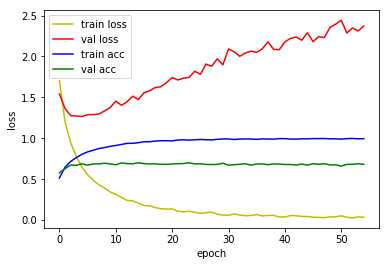

4815/4815 [==============================] - 1s 185us/sample - loss: 1.3517 - acc: 0.6584
Loss: 1.351685840442297 Accuracy: 0.6583593

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.5557 - acc: 0.5359
Epoch 00001: val_loss improved from inf to 1.14076, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_checkpoint/01-1.1408.hdf5
36805/36805 [==============================] - 14s 375us/sample - loss: 1.5549 - acc: 0.5362 - val_loss: 1.1408 - val_acc: 0.6716
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.9319 - acc: 0.7220
Epoch 00002: val_loss improved from 1.14076 to 0.90550, saving model to model/checkpoint/2D_CNN_2_only_conv_BN_checkpoint/02-0.9055.hdf5
36805/36805 [==============================] - 13s 343us/sample - loss: 0.9321 - acc: 0.7220 - val_loss: 0.9055 - val_acc: 0.7419
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.6582 - acc: 0.802

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9992
Epoch 00028: val_loss did not improve from 0.61805
36805/36805 [==============================] - 13s 341us/sample - loss: 0.0073 - acc: 0.9992 - val_loss: 0.9465 - val_acc: 0.8402
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0072 - acc: 0.9992
Epoch 00029: val_loss did not improve from 0.61805
36805/36805 [==============================] - 13s 342us/sample - loss: 0.0072 - acc: 0.9992 - val_loss: 1.0418 - val_acc: 0.8337
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9983
Epoch 00030: val_loss did not improve from 0.61805
36805/36805 [==============================] - 13s 347us/sample - loss: 0.0110 - acc: 0.9983 - val_loss: 1.0884 - val_acc: 0.8288
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0109 - acc: 0.9983
Epoch 00031: val_loss did not improve from 0.61805
36805/36805 [=====


2 Only Conv Model


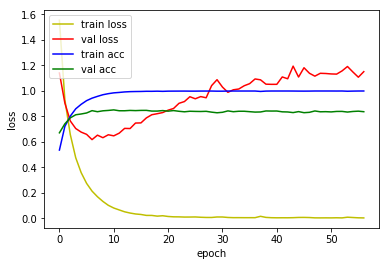

4815/4815 [==============================] - 1s 256us/sample - loss: 0.7542 - acc: 0.8056
Loss: 0.7542432006398218 Accuracy: 0.8056075

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6264 - acc: 0.5081
Epoch 00001: val_loss improved from inf to 1.10187, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_checkpoint/01-1.1019.hdf5
36805/36805 [==============================] - 16s 441us/sample - loss: 1.6260 - acc: 0.5084 - val_loss: 1.1019 - val_acc: 0.6802
Epoch 2/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.8836 - acc: 0.7355
Epoch 00002: val_loss improved from 1.10187 to 0.77927, saving model to model/checkpoint/2D_CNN_3_only_conv_BN_checkpoint/02-0.7793.hdf5
36805/36805 [==============================] - 14s 391us/sample - loss: 0.8829 - acc: 0.7358 - val_loss: 0.7793 - val_acc: 0.7843
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6228 - acc: 0.81

36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9978
Epoch 00026: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 388us/sample - loss: 0.0156 - acc: 0.9978 - val_loss: 0.4760 - val_acc: 0.8984
Epoch 27/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9981
Epoch 00027: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0144 - acc: 0.9981 - val_loss: 0.4755 - val_acc: 0.8984
Epoch 28/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0164 - acc: 0.9972
Epoch 00028: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 388us/sample - loss: 0.0163 - acc: 0.9973 - val_loss: 0.4584 - val_acc: 0.9045
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0112 - acc: 0.9985
Epoch 00029: val_loss did not improve from 0.36836
36805/36805 [==================

Epoch 56/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9995
Epoch 00056: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 387us/sample - loss: 0.0031 - acc: 0.9995 - val_loss: 0.5844 - val_acc: 0.9017
Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0031 - acc: 0.9995
Epoch 00057: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 385us/sample - loss: 0.0031 - acc: 0.9995 - val_loss: 0.5714 - val_acc: 0.9040
Epoch 58/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0027 - acc: 0.9995
Epoch 00058: val_loss did not improve from 0.36836
36805/36805 [==============================] - 14s 389us/sample - loss: 0.0027 - acc: 0.9995 - val_loss: 0.5913 - val_acc: 0.8980
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0030 - acc: 0.9995
Epoch 00059: val_loss did not improve from 0.36836
36805/36805 [=====

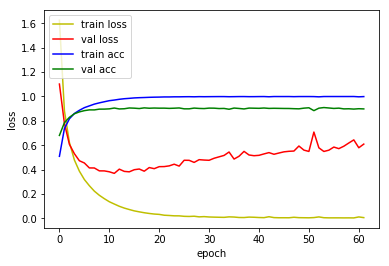

4815/4815 [==============================] - 1s 266us/sample - loss: 0.4603 - acc: 0.8791
Loss: 0.4602900238794701 Accuracy: 0.87912774

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6058 - acc: 0.5065
Epoch 00001: val_loss improved from inf to 1.04151, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_checkpoint/01-1.0415.hdf5
36805/36805 [==============================] - 18s 487us/sample - loss: 1.6048 - acc: 0.5069 - val_loss: 1.0415 - val_acc: 0.6890
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.8250 - acc: 0.7486
Epoch 00002: val_loss improved from 1.04151 to 0.69128, saving model to model/checkpoint/2D_CNN_4_only_conv_BN_checkpoint/02-0.6913.hdf5
36805/36805 [==============================] - 15s 418us/sample - loss: 0.8249 - acc: 0.7487 - val_loss: 0.6913 - val_acc: 0.7948
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5796 - acc: 0.8

Epoch 27/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9962
Epoch 00027: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 412us/sample - loss: 0.0207 - acc: 0.9962 - val_loss: 0.3453 - val_acc: 0.9199
Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0221 - acc: 0.9956
Epoch 00028: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 416us/sample - loss: 0.0221 - acc: 0.9956 - val_loss: 0.3749 - val_acc: 0.9161
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9965
Epoch 00029: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 417us/sample - loss: 0.0188 - acc: 0.9965 - val_loss: 0.3658 - val_acc: 0.9185
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9968
Epoch 00030: val_loss did not improve from 0.29785
36805/36805 [=====

Epoch 57/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9992
Epoch 00057: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 417us/sample - loss: 0.0040 - acc: 0.9992 - val_loss: 0.4142 - val_acc: 0.9259
Epoch 58/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9993
Epoch 00058: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 415us/sample - loss: 0.0037 - acc: 0.9993 - val_loss: 0.4179 - val_acc: 0.9238
Epoch 59/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0040 - acc: 0.9992
Epoch 00059: val_loss did not improve from 0.29785
36805/36805 [==============================] - 15s 415us/sample - loss: 0.0040 - acc: 0.9992 - val_loss: 0.4382 - val_acc: 0.9224
Epoch 60/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0178 - acc: 0.9949
Epoch 00060: val_loss did not improve from 0.29785
36805/36805 [=====

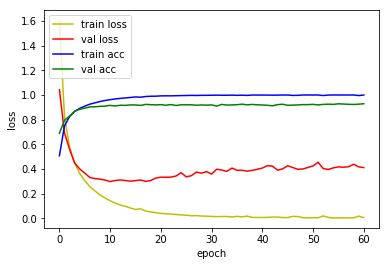

4815/4815 [==============================] - 1s 301us/sample - loss: 0.3819 - acc: 0.8866
Loss: 0.3819420781400469 Accuracy: 0.88660437



ValueError: Negative dimension size caused by subtracting 5 from 3 for 'conv2d_14/Conv2D' (op: 'Conv2D') with input shapes: [?,13,3,64], [5,5,64,128].

In [13]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN'.format(i)
    model = build_2d_cnn_only_conv_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_2d_norm, y_train_onehot, batch_size=64, epochs=200, 
                     validation_data=[x_val_2d_norm, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print('{} Only Conv Model'.format(i))
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()
    
    del(model)

In [14]:
for i in range(1, 5):
    model_name = '2D_CNN_{}_only_conv_BN'.format(i)
    print()
    print(model_name, 'Model')
#         model = build_cnn(conv_num=i, fcn_num=j)
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_2d_norm, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)


2D_CNN_1_only_conv_BN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 95, 8)        208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 253, 95, 8)        32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 48, 8)        0         
_________________________________________________________________
flatten (Flatten)            (None, 48768)             0         
_________________________________________________________________
dense (Dense)                (None, 16)                780304    
Total params: 780,544
Trainable params: 780,528
Non-trainable params: 16
_________________________________________________________________
4815/4815 [==============================] - 1s 220us/sample - loss: 1.3517 - acc: 0.6584
Loss: 1.35168584